In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir('C:\\Users\\tyler\\OneDrive\\Documents\\Python\\MLB')

In [2]:
# Load predictions
predictions = pd.read_csv('backend/data/predictions/most_hits.csv')
predictions['date'] = pd.to_datetime(predictions['date'])

In [3]:
# Merge odds
odds = pd.read_excel('backend/data/odds/most_hits.xlsx').dropna(axis=0)
odds['date'] = pd.to_datetime(odds['date'])
df = pd.merge(
    odds,
    predictions,
    left_on=['date', 'visitor', 'home'],
    right_on=['date', 'visitor', 'home']
)

In [4]:
def calc_profit(odds):
    if int(odds) > 0:
        return int(odds) / 100
    else:
        return 100 / abs(int(odds))

In [5]:
# Calculate profit
for model in ['gnb', 'log_reg', 'nn', 'rand_forest', 'svm']:
    df[f'{model}_potential_profit'] = np.where(
        df[model], 
        df['home_odds'].apply(calc_profit), 
        df['visitor_odds'].apply(calc_profit)
    )

    df[f'{model}_profit'] = np.where(
        df[model] == df['most_hits'],
        df[f'{model}_potential_profit'],
        -1
    )

    df[f'{model}_hit_bust'] = df['most_hits'] == df[model]



In [6]:
df[['date', 'visitor', 'home', 'home_odds', 'visitor_odds', 'most_hits', 'log_reg', 'log_reg_profit']].sample(10)

,date,visitor,home,home_odds,visitor_odds,most_hits,log_reg,log_reg_profit
4,2022-04-26,Boston Red Sox,Toronto Blue Jays,-145.0,110.0,0,0,1.100000
7,2022-04-29,Houston Astros,Toronto Blue Jays,-110.0,-125.0,0,0,0.800000
11,2022-05-03,Seattle Mariners,Houston Astros,-125.0,-105.0,0,0,0.952381
3,2022-04-25,San Francisco Giants,Milwaukee Brewers,-140.0,105.0,0,1,-1.000000
10,2022-05-03,Washington Nationals,Colorado Rockies,-125.0,-115.0,0,0,0.869565
0,2022-04-17,Houston Astros,Seattle Mariners,100.0,-130.0,1,0,-1.000000
2,2022-04-24,Colorado Rockies,Detroit Tigers,-115.0,-115.0,0,1,-1.000000
1,2022-04-24,Texas Rangers,Oakland Athletics,100.0,-130.0,1,0,-1.000000
12,2022-05-03,Chicago White Sox,Chicago Cubs,115.0,-155.0,0,0,0.645161
6,2022-04-28,Kansas City Royals,Chicago White Sox,-135.0,105.0,0,0,1.050000


,model,record,accuracy,profit
2,nn,9 - 4,69%,4.56
4,svm,8 - 5,62%,2.33
1,log_reg,8 - 5,62%,1.82
3,rand_forest,7 - 6,54%,0.72
0,gnb,7 - 6,54%,-0.20


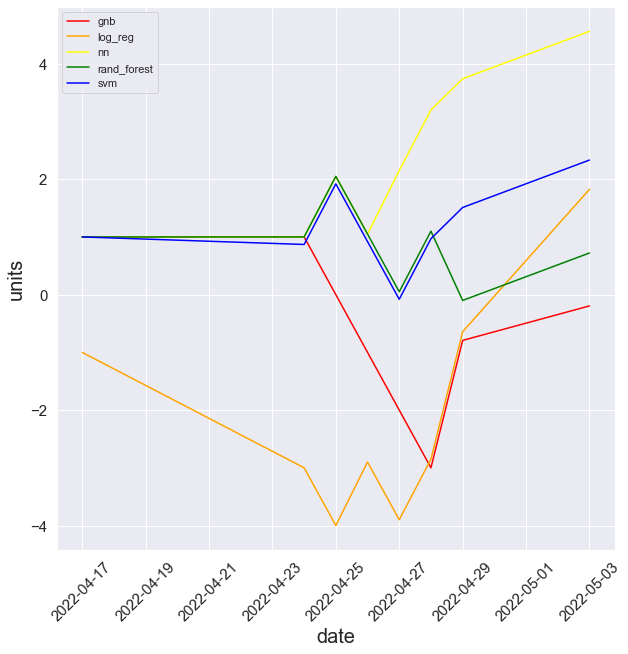

In [7]:
# Graph and print totals
sns.set(rc={"figure.figsize":(10, 10)})
sns.set_palette('bright', 8)
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)

totals = {'model': [], 'record': [], 'accuracy': [], 'profit': []}
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
models = ['gnb', 'log_reg', 'nn', 'rand_forest', 'svm']
for model, col in zip(models, colors):
    # Line graph
    sns.lineplot(
        data=df.groupby(['date']).sum(), 
        x='date', 
        y=df.groupby(['date']).sum()[f'{model}_profit'].cumsum(), 
        color=col, 
        label=model
    )
    
    # Totals
    profit = round(df[f'{model}_profit'].sum(), 2)
    correct = df[f'{model}_hit_bust'].sum()
    wrong = df[f'{model}_hit_bust'].count() - df[f'{model}_hit_bust'].sum()
    
    totals['model'].append(model)
    totals['record'].append(f'{correct} - {wrong}')
    totals['accuracy'].append(f'{round((correct / (correct + wrong) * 100))}%')
    totals['profit'].append(round(profit, 2))
    

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals